##**1. Importación de librerías y descarga de recursos**




In [1]:
!echo  " -------------- Instalando PySentimiento --------------------"
!pip install pysentimiento
# Ejecutar en terminal antes: python -m spacy download es_core_news_sm
!echo  " -------------- Descargando modelo PLN sPaCy (español) --------------------"
!python -m spacy download es_core_news_md
!echo  " -------------- Descargando modelo PLN sPaCy (español) --------------------"
!python -m spacy download en_core_web_md
!echo " -------------- Instalando Google Translate  --------------------"
!pip install googletrans==4.0.0-rc1

 -------------- Instalando PySentimiento --------------------
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.1 MB/s eta 0:00:00
 -------------- Descargando modelo PLN sPaCy (español) --------------------
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 11.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
 -------------- Descargando modelo PLN sPaCy (español) --------------------
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 56.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python

In [2]:
import pandas as pd # Librería para creación y proceasmiento de dataframes
import numpy as np  # Librería para manipulación de arrays
import re # Expresiones regulares para limpieza de datos
import nltk # PLN
from nltk.corpus import stopwords #
from nltk.tokenize import word_tokenize # Tokenización (división del texto en unidades inferiores de procesamiento)
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorización (conversión de las "palabras" en números)
from sklearn.naive_bayes import MultinomialNB # Módulo de sklearn (ML) para implementar modelos de Native Bayes
from sklearn.model_selection import train_test_split # Módulo de sklearn para divisir el dataset en datos de entrenamiento y validación
from sklearn.decomposition import LatentDirichletAllocation # Módulo de sklearn para analizar tópicos
from sklearn.metrics import  f1_score, classification_report # Módulo de sklearn para aplicar métricas de rendimiento sobre los modelos
from textblob import TextBlob #Análisis de sentimientos
from googletrans import Translator # Traducción de textos
from  pysentimiento import create_analyzer # Librería alternativa a TextBlob especializada en lengua española
import spacy # Lemantización
from tqdm import tqdm # Permite definir el método apply dinámico
import sys # Librería que permite manipular paths
import matplotlib.pyplot as plt # Librería para creación de gráficos
import seaborn as sns # Librería para creación de gráficos basada en matplotlib
import joblib # Librería para guardar modelos entrenados
from google.colab import files # Librería para descargar archivos generados

In [3]:
# Descargar recursos de NLTK necesarios
nltk.download('punkt') # Recurso encargado de tokenizar (división del texto en unidades más pequeñas, normalmente palabras)
nltk.download('stopwords') # Recurso que contiene palabras muy comunes que no aportan significado temático por sí solas.
nltk.download('punkt_tab') # Recurso que asegura la compatibilidad del sistema de división de palabras y frases.

#

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [119]:
# Ejecutar en terminal antes: python -m spacy download es_core_news_sm
try:
    nlp_es = spacy.load("es_core_news_md") # Descargamos un modelo pre-entrenado en español
    nlp_en = spacy.load("en_core_news_md") # Descargamos un modelo pre-entrenado en inglés

except:
    print("Spacy model non found. Execute: python -m spacy download <en/es>_core_news_md")

Spacy model non found. Execute: python -m spacy download <en/es>_core_news_md


#**2. Importación de los ficheros csv y generación del dataframe general**

In [120]:
# Leemos los ficheros csv generados previamente con el notebook "extraccion" ubicados en el respositorio de github
# Pasamos los datos a dataframes de pandas, añadimos una columna "source" donde indicamos el origen de los mensajes cargados
url_base_github = 'https://raw.githubusercontent.com/rsolis-utamed/pln_practica/main'
url_data=f"{url_base_github}/data"

data_sources=['cotilleando','minube','forocoches']
file_1_name = f'data_{data_sources[0]}.csv'
file_2_name = f'data_{data_sources[1]}.csv'
file_3_name= f'data_{data_sources[2]}.csv'
#

df_1 = pd.read_csv(f'{url_data}/{file_1_name}', on_bad_lines='skip', encoding='utf-8')
df_1['source']=data_sources[0]
df_2 = pd.read_csv(f'{url_data}/{file_2_name}', on_bad_lines='skip', encoding='utf-8')
df_2['source']=data_sources[1]
df_3 = pd.read_csv(f'{url_data}/{file_3_name}', on_bad_lines='skip', encoding='utf-8')
df_3['source']=data_sources[2]

In [121]:
# Unificamos los 3 dataframes en un único datagrame general
df_combined = pd.concat([df_1, df_2, df_3], ignore_index=True)
display(df_combined.head())

,Mensaje,source
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando


#**3. Preprocesamiento**

In [122]:
# Palabras encontradas en topicos generados anteriormente (en pruebas previas) que se ha considearo que no aportan valor. Se incorporan dentro de
# el resto de stopwords
ruido_nuevo = ["shur", "ronda", "asperón" , "zbe"]

In [8]:
# Desargamos el respositorio donde tenemos el código (Lo vamos a emplear para ejecutar la clase Preprocessor.py)
!git clone https://github.com/rsolis-utamed/pln_practica.git

Cloning into 'pln_practica'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 87 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 358.54 KiB | 2.60 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [9]:
#Actualizamos el el contenido del repositorio (si procede)
!cd /content/pln_practica && git pull

Already up to date.


In [10]:
# Definimos un path para poder trabajar con scripts python subidos al respositorio
sys.path.append('/content/pln_practica/code')

In [123]:
# Importamos la clase propia preprocessor del reposistorio github
from Preprocessor import Preprocessor
tqdm.pandas() # Este paso nos permite aplcar "process_apply" en lugar de apply genérico. Nos ofrece de forma dinámia el porcentaje de ejecución del proceso.
preprocesador=Preprocessor(nlp_en,ruido_nuevo)
col_texto='Mensaje' # Nombre que posee la columna con los comentarios en los ficheros csv que componen el corpus
print("Preprocesando textos...")
df_combined['texto_limpio'] = df_combined[col_texto].progress_apply(preprocesador.toPreprocessText)
print("Textos procesados")

version 2.1.0
Preprocesando textos...


 14%|█▍        | 7/50 [00:00<00:00, 66.21it/s]

   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regula

 28%|██▊       | 14/50 [00:00<00:00, 42.31it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

 62%|██████▏   | 31/50 [00:00<00:00, 66.38it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

100%|██████████| 50/50 [00:00<00:00, 65.08it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

# **4. Vectorización**

In [172]:
# Uso de IF-IDF para vectorizar los tokens (conversión en vectores numéricos). Pondera positivamente las palabras que aparecen en pocos documentos.
# max_features: vamos quedarnos con las 1500 palabras más importantes del corpues
# min_df: una palabra debe aparecer al menos 2 veces para tenerse en consideración
# max_df: las palabras que aparecen en más del 80% de los documentos no se tendrán en consideración
vectorizer = TfidfVectorizer(max_features=1500, min_df=2, max_df=0.80, stop_words=list(set(stopwords.words('spanish')).union(set(ruido_nuevo))))
X = vectorizer.fit_transform(df_combined['texto_limpio'])
print(f"Number of features after fitting vectorizer: {X.shape[1]}")

Number of features after fitting vectorizer: 201


In [173]:
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,-0.001145,Neutro,NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.425000,Positivo,NEG
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.058333,Positivo,POS
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomar yo él personal mudar madrid...,0.083622,Positivo,POS
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,decir mejor andalucía pensar trasladarme allíp...,0.500000,Positivo,NEG


# **5. Análisis de sentimienento**

## 5.1. Uso TextBlob

In [126]:
# Como no tenemos etiquetas manuales, usamos TextBlob para estimarlas.
# Nota: TextBlob nativo es inglés, por lo que al usar el modelo pre-entrenado en español los resultados serán menos precisos. En el siguiente apartado emplearemos
# PySentimiento como alternativa y contrastaremos los resultados de ambas opciones.
# Aquí usamos una lógica simple: si polarity > 0 es Positivo.

def obtener_polaridad(texto):
    """
    TextBlob arroja un valor entre -1 y 1. Si el valor es mayor. Siendo -1: Negativo Máximo, 0: Neutro, 1: Positivo Máximo
    """
    translator = Translator()
    texto_en = translator.translate(texto, src='es', dest='en').text
    analysis = TextBlob(texto_en)
    return analysis.sentiment.polarity

df_combined['score_polaridad_TextB'] = df_combined['texto_limpio'].apply(obtener_polaridad)
"""
TextBlob arroja un valor entre -1 y 1. Si el valor es mayor. Siendo -1: Negativo Máximo, 0: Neutro, 1: Positivo Máximo

"""
def clasificar_sentimiento(score):
    """
    Esta función permite clasificar los Positivos, Negativos y Neutros segun el valor de score.
    """
    if score  >= 0.05: return 'Positivo'
    elif score <=  -0.05: return 'Negativo'
    else: return 'Neutro'

df_combined['sentimiento_TextB'] = df_combined['score_polaridad_TextB'].apply(clasificar_sentimiento)

print("\n--- Polaridad (TextBlob) ---")
df_combined[[col_texto,'score_polaridad_TextB' ,'sentimiento_TextB']].head(5)


--- Polaridad (TextBlob) ---


,Mensaje,score_polaridad_TextB,sentimiento_TextB
0,"Pues eso... Así literal, para mi gusto Málaga ...",-0.001145,Neutro
1,"Qué pena, de verdad, hace que no voy unos seis...",0.425000,Positivo
2,"me da pena lo que dices, pase un par de temmpo...",0.058333,Positivo
3,No puedo evitar tomármelo a lo personal (hasta...,0.083622,Positivo
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",0.500000,Positivo


In [127]:
df_positivos = df_combined[df_combined['sentimiento_TextB'] == 'Positivo']
df_positivos[[col_texto, 'score_polaridad_TextB', 'sentimiento_TextB']].head(5)

,Mensaje,score_polaridad_TextB,sentimiento_TextB
1,"Qué pena, de verdad, hace que no voy unos seis...",0.425000,Positivo
2,"me da pena lo que dices, pase un par de temmpo...",0.058333,Positivo
3,No puedo evitar tomármelo a lo personal (hasta...,0.083622,Positivo
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",0.500000,Positivo
5,"Málaga tendrá de todo, pero últimamente esta e...",0.352381,Positivo


In [128]:
df_negativos = df_combined[df_combined['sentimiento_TextB'] == 'Negativo']
df_negativos[[col_texto, 'score_polaridad_TextB', 'sentimiento_TextB']].head(5)

,Mensaje,score_polaridad_TextB,sentimiento_TextB
7,Dicho sea primero que no he pisado Málaga en m...,-0.221154,Negativo
9,Otro malagueño por aquí y coincido con algunos...,-0.200000,Negativo
16,Paula LizanoEl frio nos dió una tregua durante...,-0.366667,Negativo
23,La cruz verde,-0.100000,Negativo
24,"El alquiler, aquí en general, es una puta mierda.",-0.075000,Negativo


## 5.2. Uso PySentimiento

In [129]:
# Uso alternativo de PySentimiento en lugar de TextBlob
finiteautomata="finiteautomata/beto-sentiment-analysis" # Modelo Textos formales, noticias, correos, reseñas.
robertuito="pysentimiento/robertuito-sentiment-analysis" # Textos cortos, emojis, redes sociales.
task="sentiment"
analyzer=create_analyzer(task="sentiment",model_name=finiteautomata, lang="es")

def clasificador_esp(texto):
  resultado=analyzer.predict(texto)
  return resultado.output # output: POS , NEG , NEU

df_combined['sentimiento_PySent'] = df_combined['texto_limpio'].apply(clasificador_esp)

print("\n--- Polaridad (PySentimiento) ---")
df_combined[[col_texto, 'sentimiento_PySent']].head(5)


--- Polaridad (PySentimiento) ---


,Mensaje,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",NEG
2,"me da pena lo que dices, pase un par de temmpo...",POS
3,No puedo evitar tomármelo a lo personal (hasta...,POS
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",NEG


In [130]:
df_positivos = df_combined[df_combined['sentimiento_PySent'] == 'POS']
df_positivos[[col_texto, 'sentimiento_PySent']].head(5)

,Mensaje,sentimiento_PySent
2,"me da pena lo que dices, pase un par de temmpo...",POS
3,No puedo evitar tomármelo a lo personal (hasta...,POS
5,"Málaga tendrá de todo, pero últimamente esta e...",POS
10,Igual tienes que viajar un poco dentro y fuera...,POS
13,Rafael VilchesMucho que verExcelenteCapital y ...,POS


In [131]:
df_negativos = df_combined[df_combined['sentimiento_PySent'] == 'NEG']
df_negativos[[col_texto, 'sentimiento_PySent']].head(5)

,Mensaje,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",NEG
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",NEG
6,"Y a mi me ha dado asco tu comentario, así lite...",NEG
7,Dicho sea primero que no he pisado Málaga en m...,NEG


In [132]:
# Visualizamos en el dataframe general las columnas generadas con la polaridad de TextBlob y PySentimiento. Podemos apreciar como la polaridad es reflejada
# de manera más ajustada con PySentimiento
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,-0.001145,Neutro,NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.425000,Positivo,NEG
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.058333,Positivo,POS
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomar yo él personal mudar madrid...,0.083622,Positivo,POS
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,decir mejor andalucía pensar trasladarme allíp...,0.500000,Positivo,NEG


#**6. Modelado de tópicos (LDA)**

In [174]:
# Tras varias ejecuciones probando a generar entre 3-8 tópicos hemos decidido que el modelo genere  3 en función de la perplexidad (métrica) y la coherencia (revisión manual de palabras)
# A continuación le asignamos un nombre representativo a cada uno de ellos en función de las palabras que lo componen.
nombre_topicos={
    0: 'Identidad y ciudad',
    1: 'Lugares y localidades' ,
    2: 'Alquiler y trabajo'
 }

In [175]:


# Modelo que permite descubrir los temas latentes (clusters) sin necesidad de etiquetas. Definimos 5 tópicos y la semilla aleatoria en 42.
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_output = lda_model.fit_transform(X)

print("\n--- Tópicos Descubiertos (Palabras clave) ---")
feature_names = vectorizer.get_feature_names_out()

# Asignamos el tópico dominante a cada texto
df_combined['topico'] = lda_output.argmax(axis=1)
df_combined['topico_desc'] = df_combined['topico'].map(nombre_topicos)

print("\n--- Modelado tópicos (LDA) ---")
df_combined[[col_texto, 'topico_desc']].head(5)


--- Tópicos Descubiertos (Palabras clave) ---

--- Modelado tópicos (LDA) ---


,Mensaje,topico_desc
0,"Pues eso... Así literal, para mi gusto Málaga ...",Identidad y ciudad
1,"Qué pena, de verdad, hace que no voy unos seis...",Identidad y ciudad
2,"me da pena lo que dices, pase un par de temmpo...",Identidad y ciudad
3,No puedo evitar tomármelo a lo personal (hasta...,Identidad y ciudad
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",Lugares y localidades


In [107]:
# Visualizamos los 5 tópicos generados y sus 10 palabras más relevantes
for idx, topic in  enumerate(lda_model.components_):
    print(f"Tópico {nombre_topicos[idx]}: ", [feature_names[i] for i in topic.argsort()[:-11:-1]])

Tópico Identidad y ciudad:  ['siempre', 'calle', 'malagueño', 'dar', 'barrio', 'málaga', 'haber', 'cultural', 'lujo', 'tener']
Tópico Lugares y localidades:  ['málaga', 'haber', 'centro', 'ser', 'hacer', 'nuevo', 'calle', 'cultural', 'lujo', 'histórico']
Tópico Alquiler y trabajo:  ['malagueta', 'gran', 'capital', 'tener', 'parte', 'málaga', 'calle', 'haber', 'cultural', 'lujo']


In [134]:
# Podemos apreciar en el dataset las columnas correspondientes a la polaridad con ambas librerías y la clasificación en tópicos
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,-0.001145,Neutro,NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.425000,Positivo,NEG
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.058333,Positivo,POS
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomar yo él personal mudar madrid...,0.083622,Positivo,POS
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,decir mejor andalucía pensar trasladarme allíp...,0.500000,Positivo,NEG


## 5.Visualización de resultados

##5.1. Palabras por tópico

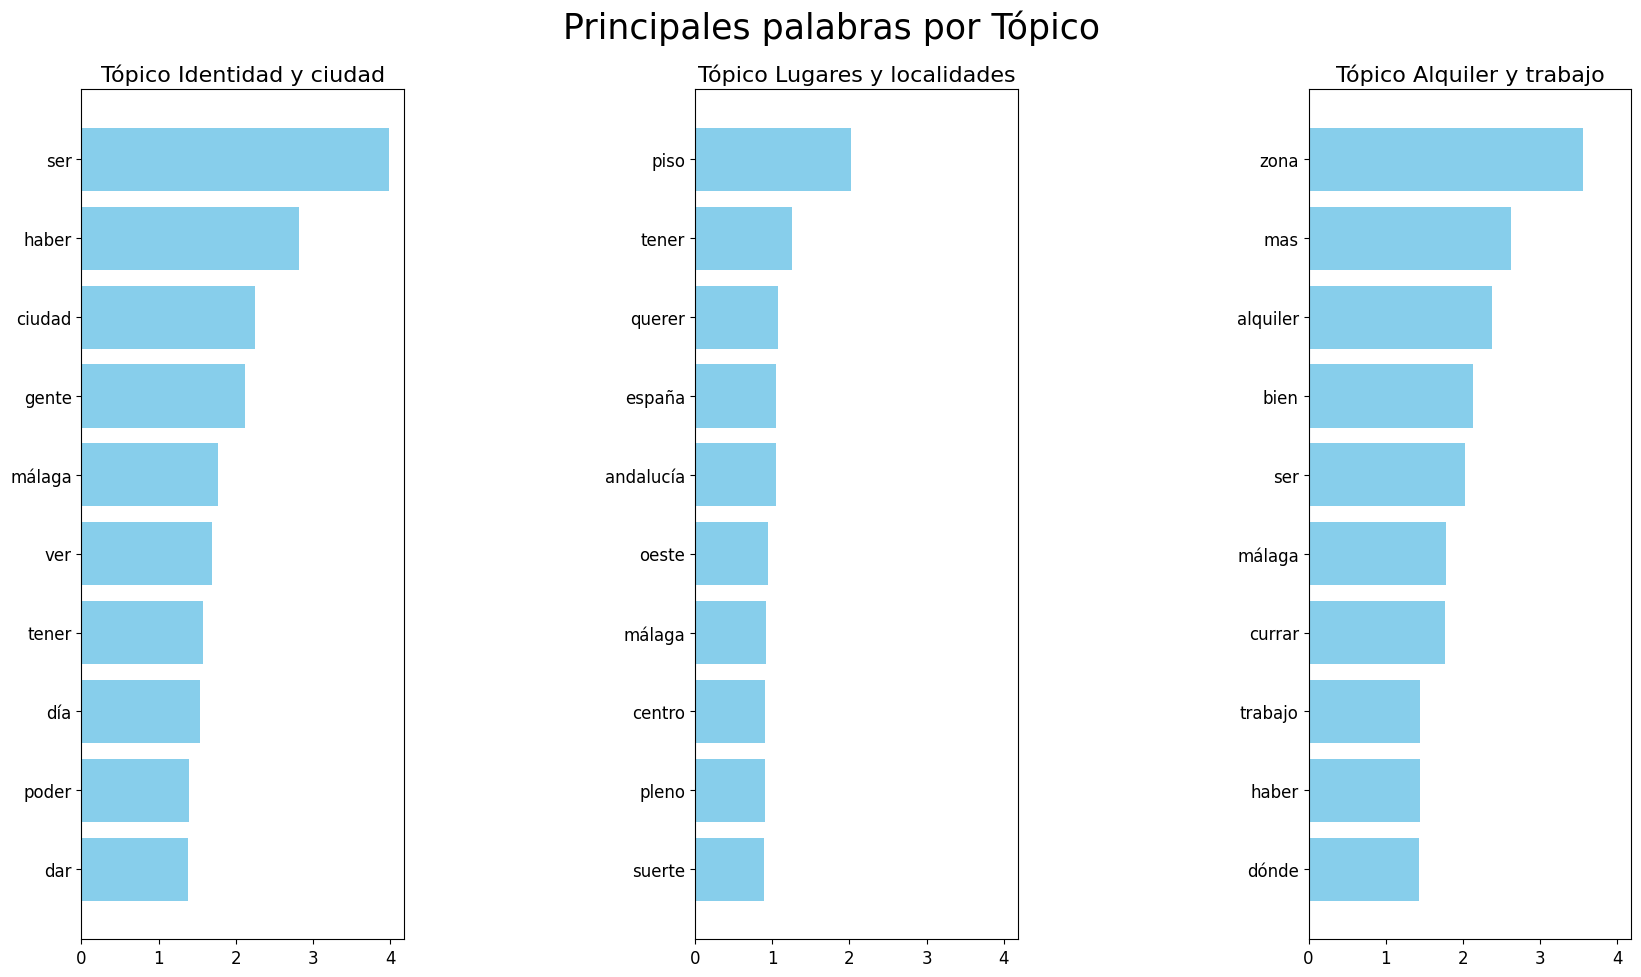

In [25]:

def plot_top_words(model, feature_names, n_top_words, title):
    # Ajustamos el grid según la cantidad de tópicos (ej. 10 tópicos en 2 filas)
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        # Obtener los índices de las palabras con mayores pesos
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f"Tópico {nombre_topicos[topic_idx]}", fontdict={"fontsize": 16})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=12)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=25)
    plt.show()

# Ejemplo de uso:
# 'lda' es tu modelo entrenado, 'vectorizer' es tu CountVectorizer o TfidfVectorizer
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 10, "Principales palabras por Tópico")

##5.2. Número de documentos por tópico

/tmp/ipython-input-955367360.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


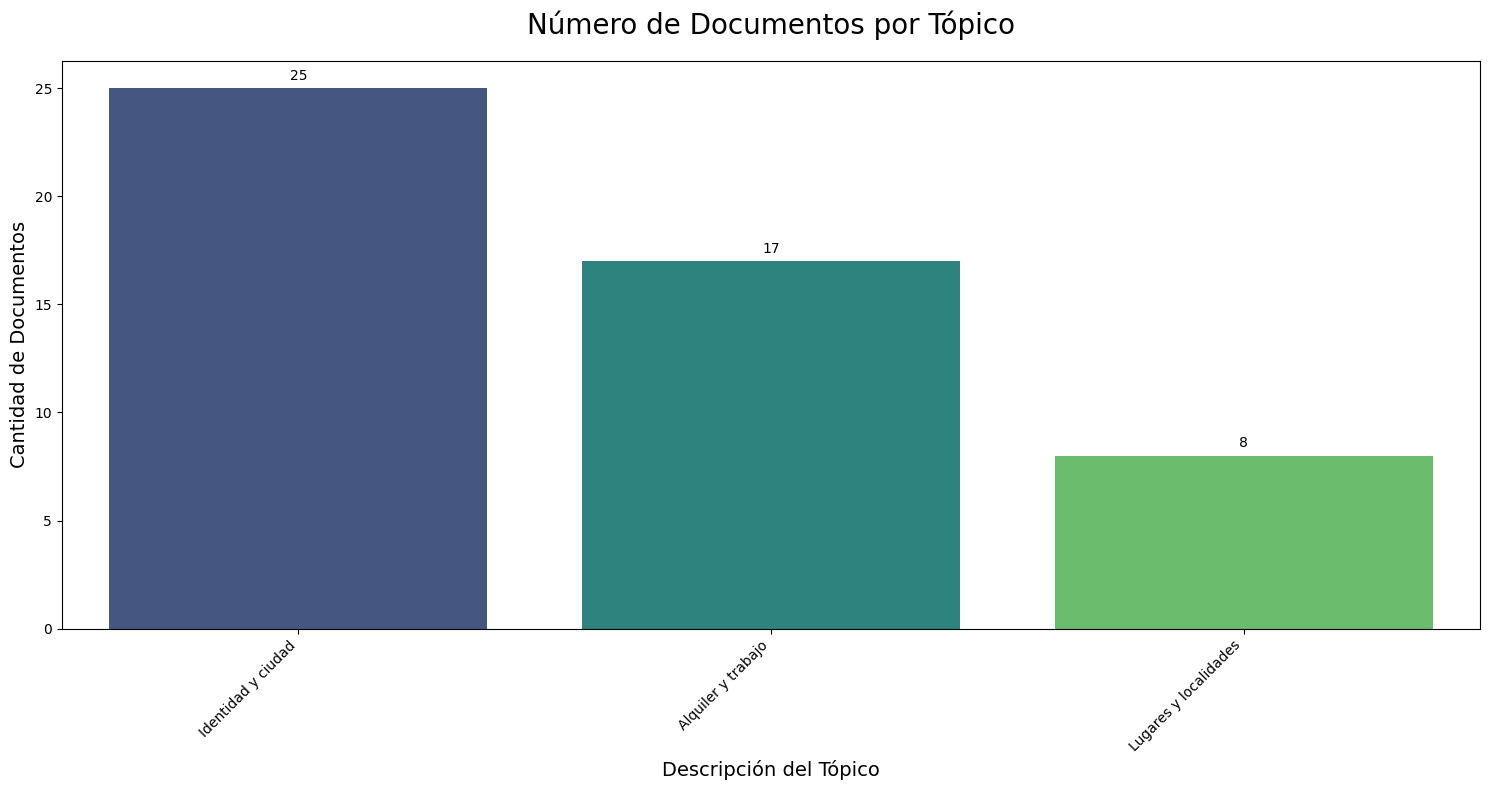

In [68]:


# 1. Configurar el tamaño del gráfico
plt.figure(figsize=(15, 8))

# 2. Crear el gráfico de conteo (Countplot)

ax = sns.countplot(
    data=df_combined,
    x='topico_desc',
    palette='viridis',
    order=df_combined['topico_desc'].value_counts().index # Ordena de mayor a menor
)

# 3. Personalización estética
plt.title('Número de Documentos por Tópico', fontsize=20, pad=20)
plt.xlabel('Descripción del Tópico', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)

# Rotar las etiquetas del eje X para que sean legibles
plt.xticks(rotation=45, ha='right')

# Añadir el número exacto encima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()


##6. Predicción y validación (Etiquetas generadas artificialmente)

##6.1. Predicción y métricas de validación (Análisis de sentimientos - TextBlob)

In [135]:
# Empleamos un modelo de predicción Naive Bayes
y = df_combined['sentimiento_TextB']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) # Dividimos esl set de datos en 80% para entrenamiento y 20% para validación
# 2. Instanciamos el modelo Naive Bayes (Multinomial es ideal para conteo de palabras)
clf_textb = MultinomialNB()
# 3. Entrenamos el modelo con el set de entrenamiento
clf_textb.fit(X_train, y_train)
# 4. Efectuamos la predicción usando el set de validación
y_pred = clf_textb.predict(X_valid)

In [136]:
# Calculamos F1 Score (usamos un nombre de variable distinto a la función)
f1_resultado = f1_score(y_valid, y_pred, average='weighted')
print(f"F1 Score: {f1_resultado:.5f}")
print(classification_report(y_valid,y_pred))

F1 Score: 0.57647
              precision    recall  f1-score   support

      Neutro       0.00      0.00      0.00         3
    Positivo       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##6.2. Predicción y métricas de validación (Análisis de sentimientos - PySentimiento)

In [137]:
y = df_combined['sentimiento_PySent']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) # Dividimos esl set de datos en 80% para entrenamiento y 20% para validación
# 2. Instanciamos el modelo Naive Bayes (Multinomial es ideal para conteo de palabras)
clf_pysent = MultinomialNB()
# 3. Entrenamos el modelo con el set de entrenamiento
clf_pysent.fit(X_train, y_train)
# 4. Efectuamos la predicción usando el set de validación
y_pred = clf_pysent.predict(X_valid)


In [138]:

# Calculamos F1 Score (usamos un nombre de variable distinto a la función)
f1_resultado = f1_score(y_valid, y_pred, average='weighted')
print(f"F1 Score: {f1_resultado:.5f}")
print(classification_report(y_valid,y_pred))

F1 Score: 0.49048
              precision    recall  f1-score   support

         NEG       1.00      0.50      0.67         2
         NEU       0.56      1.00      0.71         5
         POS       0.00      0.00      0.00         3

    accuracy                           0.60        10
   macro avg       0.52      0.50      0.46        10
weighted avg       0.48      0.60      0.49        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##6.3. Predicción y métricas de validación Modelado de Tópicos (LDA)

In [139]:
df_combined.head(4)

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,-0.001145,Neutro,NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.425000,Positivo,NEG
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.058333,Positivo,POS
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomar yo él personal mudar madrid...,0.083622,Positivo,POS


#**7. Testing**
*   Datos generado sintéticamente (mensajes) y etiquetas generadas de forma manual.
*   Datos generados con clases balaceadas: 5 Negativos, 5 Positivos y 5 Neutros



##7.1 Selección del set de datos para el test

In [140]:
# Una vez efectuadas las métricas sobre el set de datos de entrenamiento y validación, donde en ambos casos las etiquetas han sido generadas automáticamente a través de TextBlob y PySentimiento
# Se ha generado un set de datos balanceado con 5 casos de cada una de las clases con su correspondiente etiqueta informada manualmente y tomada como real
# Sobre este set de datos probaremos el rendimiento real de los modelos de análisis de sentimiento
dataset_test= [
    # POSITIVAS
    {"Mensaje": "El nuevo sistema de Metro en Málaga es puntual y facilita muchísimo llegar al centro.", "polaridad": "Positivo"},
    {"Mensaje": "Las calles del Soho están impecables y el arte urbano les da una vida increíble.", "polaridad": "Positivo"},
    {"Mensaje": "Me sorprendió la amabilidad de la ciudadanía malagueña; siempre están dispuestos a ayudar al turista.", "polaridad": "Positivo"},
    {"Mensaje": "El hotel frente a la Malagueta tenía unas vistas espectaculares y un servicio de diez.", "polaridad": "Positivo"},
    {"Mensaje": "La limpieza en la zona de la calle Larios es constante, se nota que cuidan mucho la imagen de la ciudad.", "polaridad": "Positivo"},

    # NEGATIVAS
    {"Mensaje": "Es imposible aparcar en el centro de Málaga y los parkings públicos son extremadamente caros.", "polaridad": "Negativo"},
    {"Mensaje": "El alojamiento en el centro histórico hace mucho ruido por la noche debido a las terrazas.", "polaridad": "Negativo"},
    {"Mensaje": "He visto varias calles secundarias cerca de la Victoria que necesitan una limpieza profunda de forma urgente.", "polaridad": "Negativo"},
    {"Mensaje": "El transporte público hacia los barrios de la periferia tarda demasiado y siempre va masificado.", "polaridad": "Negativo"},
    {"Mensaje": "La gentrificación está haciendo que el alquiler para los ciudadanos de Málaga sea totalmente inasumible.", "polaridad": "Negativo"},

    # NEUTRAS
    {"Mensaje": "Málaga cuenta con una red de autobuses urbanos que recorre gran parte de la capital.", "polaridad": "Neutro"},
    {"Mensaje": "Hay varios hoteles de cuatro estrellas ubicados en las inmediaciones de la estación María Zambrano.", "polaridad": "Neutro"},
    {"Mensaje": "El Ayuntamiento de Málaga ha anunciado nuevas medidas de limpieza para el próximo trimestre.", "polaridad": "Neutro"},
    {"Mensaje": "La ciudadanía de Málaga se prepara para los eventos culturales programados este fin de semana.", "polaridad": "Neutro"},
    {"Mensaje": "Existen diferentes opciones de alojamiento, desde hostales económicos hasta hoteles de lujo en Málaga.", "polaridad": "Neutro"}
]


In [141]:
test_df = pd.DataFrame(dataset_test)
test_df.head(2)

,Mensaje,polaridad
0,El nuevo sistema de Metro en Málaga es puntual...,Positivo
1,Las calles del Soho están impecables y el arte...,Positivo


#7.2 Preprocesamiento y vectorización del set dedatos

In [142]:
preprocesador=Preprocessor(nlp_en,ruido_nuevo)
test_df["Mensaje_procesado"]=test_df["Mensaje"].progress_apply(preprocesador.toPreprocessText)
test_df.head(5)

version 2.1.0


 40%|████      | 6/15 [00:00<00:00, 56.59it/s]

   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regula

 80%|████████  | 12/15 [00:00<00:00, 42.49it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...


100%|██████████| 15/15 [00:00<00:00, 32.35it/s]


   Lemmantizing text...
   Deleting stop words in text...


,Mensaje,polaridad,Mensaje_procesado
0,El nuevo sistema de Metro en Málaga es puntual...,Positivo,nuevo sistema metro málaga ser puntual facilit...
1,Las calles del Soho están impecables y el arte...,Positivo,calle soho impecable arte urbano dar vida incr...
2,Me sorprendió la amabilidad de la ciudadanía m...,Positivo,sorprender amabilidad ciudadanía malagueño sie...
3,El hotel frente a la Malagueta tenía unas vist...,Positivo,hotel frente malagueta tener vista espectacula...
4,La limpieza en la zona de la calle Larios es c...,Positivo,limpieza zona calle larios ser constante notar...


In [143]:
# Vectorización
X_test = vectorizer.transform(test_df['Mensaje_procesado'])


In [144]:
X.shape

(50, 201)

In [149]:
y = df_combined['sentimiento_TextB']
clf_textb = MultinomialNB() # Instanciamos el modelo Naive Bayes
clf_textb.fit(X, y) # Entrenamos el modelo con todos el set de datos
test_df["Pol_TextB_Predict"]=clf_textb.predict(X_test)
test_df.head(15)


,Mensaje,polaridad,Mensaje_procesado,Pol_TextB_Predict,Pol_PySent_Predict,Pol_PySent_Predict_Norm
0,El nuevo sistema de Metro en Málaga es puntual...,Positivo,nuevo sistema metro málaga ser puntual facilit...,Positivo,NEU,Neutro
1,Las calles del Soho están impecables y el arte...,Positivo,calle soho impecable arte urbano dar vida incr...,Positivo,NEG,Negativo
2,Me sorprendió la amabilidad de la ciudadanía m...,Positivo,sorprender amabilidad ciudadanía malagueño sie...,Positivo,NEU,Neutro
3,El hotel frente a la Malagueta tenía unas vist...,Positivo,hotel frente malagueta tener vista espectacula...,Positivo,NEU,Neutro
4,La limpieza en la zona de la calle Larios es c...,Positivo,limpieza zona calle larios ser constante notar...,Positivo,NEU,Neutro
5,Es imposible aparcar en el centro de Málaga y ...,Negativo,ser imposible aparcar centro málaga parking pú...,Positivo,NEU,Neutro
6,El alojamiento en el centro histórico hace muc...,Negativo,alojamiento centro histórico hacer ruido noche...,Positivo,POS,Positivo
7,He visto varias calles secundarias cerca de la...,Negativo,haber ver varios calle secundario cerca victor...,Positivo,NEU,Neutro
8,El transporte público hacia los barrios de la ...,Negativo,transporte público hacia barrio periferia tard...,Positivo,NEU,Neutro
9,La gentrificación está haciendo que el alquile...,Negativo,gentrificación hacer alquiler ciudadano málaga...,Positivo,NEG,Negativo


In [150]:
y = df_combined['sentimiento_PySent']
clf_pysent = MultinomialNB() # Instanciamos el modelo Naive Bayes
clf_pysent.fit(X, y)
test_df["Pol_PySent_Predict"]=clf_pysent.predict(X_test)

def renombrado_polaridad(polaridad):
  """
  Función para homogenizar las etiquetas de PySentimiento con las de TextBlob
  """
  if polaridad == 'POS': return 'Positivo'
  elif polaridad == 'NEG': return 'Negativo'
  else: return 'Neutro'

test_df["Pol_PySent_Predict_Norm"]=test_df["Pol_PySent_Predict"].apply(renombrado_polaridad)
test_df.head(15)

,Mensaje,polaridad,Mensaje_procesado,Pol_TextB_Predict,Pol_PySent_Predict,Pol_PySent_Predict_Norm
0,El nuevo sistema de Metro en Málaga es puntual...,Positivo,nuevo sistema metro málaga ser puntual facilit...,Positivo,NEU,Neutro
1,Las calles del Soho están impecables y el arte...,Positivo,calle soho impecable arte urbano dar vida incr...,Positivo,NEG,Negativo
2,Me sorprendió la amabilidad de la ciudadanía m...,Positivo,sorprender amabilidad ciudadanía malagueño sie...,Positivo,NEU,Neutro
3,El hotel frente a la Malagueta tenía unas vist...,Positivo,hotel frente malagueta tener vista espectacula...,Positivo,NEU,Neutro
4,La limpieza en la zona de la calle Larios es c...,Positivo,limpieza zona calle larios ser constante notar...,Positivo,NEU,Neutro
5,Es imposible aparcar en el centro de Málaga y ...,Negativo,ser imposible aparcar centro málaga parking pú...,Positivo,NEU,Neutro
6,El alojamiento en el centro histórico hace muc...,Negativo,alojamiento centro histórico hacer ruido noche...,Positivo,POS,Positivo
7,He visto varias calles secundarias cerca de la...,Negativo,haber ver varios calle secundario cerca victor...,Positivo,NEU,Neutro
8,El transporte público hacia los barrios de la ...,Negativo,transporte público hacia barrio periferia tard...,Positivo,NEU,Neutro
9,La gentrificación está haciendo que el alquile...,Negativo,gentrificación hacer alquiler ciudadano málaga...,Positivo,NEG,Negativo


In [147]:
f1_resultado_tb = f1_score(test_df["polaridad"], test_df["Pol_TextB_Predict"], average='weighted')
print(f"F1 Score: {f1_resultado_tb:.5f}")
print(classification_report(test_df["polaridad"], test_df["Pol_TextB_Predict"]))

F1 Score: 0.16667
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         5
      Neutro       0.00      0.00      0.00         5
    Positivo       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [151]:
f1_resultado_py = f1_score(test_df["polaridad"], test_df["Pol_PySent_Predict_Norm"], average='weighted')
print(f"F1 Score: {f1_resultado_py:.5f}")
print(classification_report(test_df["polaridad"], test_df["Pol_PySent_Predict_Norm"]))

F1 Score: 0.29132
              precision    recall  f1-score   support

    Negativo       0.50      0.20      0.29         5
      Neutro       0.42      1.00      0.59         5
    Positivo       0.00      0.00      0.00         5

    accuracy                           0.40        15
   macro avg       0.31      0.40      0.29        15
weighted avg       0.31      0.40      0.29        15



In [183]:
topic_prediction = lda_model.transform(X_test)
dominant_topic_idx =topic_prediction.argmax(axis=1)
test_df['topico_predict'] = dominant_topic_idx
test_df['topico_predict_desc'] = test_df['topico_predict'].map(nombre_topicos)
perplexity=lda_model.perplexity(X_test)
print(f"Perplexidad: {perplexity}")
test_df.head(15)

Perplexidad: 15856.726529765903


,Mensaje,polaridad,Mensaje_procesado,Pol_TextB_Predict,Pol_PySent_Predict,Pol_PySent_Predict_Norm,topico_predict,topico_predict_desc
0,El nuevo sistema de Metro en Málaga es puntual...,Positivo,nuevo sistema metro málaga ser puntual facilit...,Positivo,NEU,Neutro,0,Identidad y ciudad
1,Las calles del Soho están impecables y el arte...,Positivo,calle soho impecable arte urbano dar vida incr...,Positivo,NEG,Negativo,0,Identidad y ciudad
2,Me sorprendió la amabilidad de la ciudadanía m...,Positivo,sorprender amabilidad ciudadanía malagueño sie...,Positivo,NEU,Neutro,0,Identidad y ciudad
3,El hotel frente a la Malagueta tenía unas vist...,Positivo,hotel frente malagueta tener vista espectacula...,Positivo,NEU,Neutro,0,Identidad y ciudad
4,La limpieza en la zona de la calle Larios es c...,Positivo,limpieza zona calle larios ser constante notar...,Positivo,NEU,Neutro,0,Identidad y ciudad
5,Es imposible aparcar en el centro de Málaga y ...,Negativo,ser imposible aparcar centro málaga parking pú...,Positivo,NEU,Neutro,0,Identidad y ciudad
6,El alojamiento en el centro histórico hace muc...,Negativo,alojamiento centro histórico hacer ruido noche...,Positivo,POS,Positivo,0,Identidad y ciudad
7,He visto varias calles secundarias cerca de la...,Negativo,haber ver varios calle secundario cerca victor...,Positivo,NEU,Neutro,2,Alquiler y trabajo
8,El transporte público hacia los barrios de la ...,Negativo,transporte público hacia barrio periferia tard...,Positivo,NEU,Neutro,0,Identidad y ciudad
9,La gentrificación está haciendo que el alquile...,Negativo,gentrificación hacer alquiler ciudadano málaga...,Positivo,NEG,Negativo,0,Identidad y ciudad


#7. Conservación de los modelos generadosy descarga de los mismos

In [152]:

# Guardamos los modelos entrenados para poderlos emplear directamente en el notebook "chat_ia"
joblib.dump(clf_textb, 'text_blob_model.joblib')
joblib.dump(clf_pysent, 'py_sentiment_model.joblib')
joblib.dump(lda_model, 'lda_topics_model.joblib')
joblib.dump(vectorizer, 'vectorizador_tfidf.joblib')

['vectorizador_tfidf.joblib']

In [153]:
# Descargar los archivos creados
files.download('text_blob_model.joblib')
files.download('py_sentiment_model.joblib')
files.download('lda_topics_model.joblib')
files.download('vectorizador_tfidf.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>